C:\Users\pawel\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Additional feature engineering complete.
Random Forest Classification Report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      9301
     running       1.00      1.00      1.00     30492
      stairs       0.98      0.89      0.93      1494
     walking       0.99      1.00      0.99     16869

    accuracy                           1.00     58156
   macro avg       0.99      0.97      0.98     58156
weighted avg       1.00      1.00      1.00     58156

Random Forest Accuracy Score: 0.9965093885411651


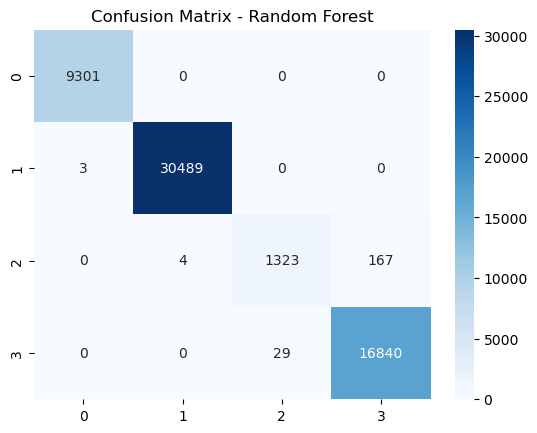

SVM Classification Report:
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      9301
     running       1.00      1.00      1.00     30492
      stairs       0.00      0.00      0.00      1494
     walking       0.92      1.00      0.96     16869

    accuracy                           0.97     58156
   macro avg       0.73      0.75      0.74     58156
weighted avg       0.95      0.97      0.96     58156

SVM Accuracy Score: 0.9742588898823853


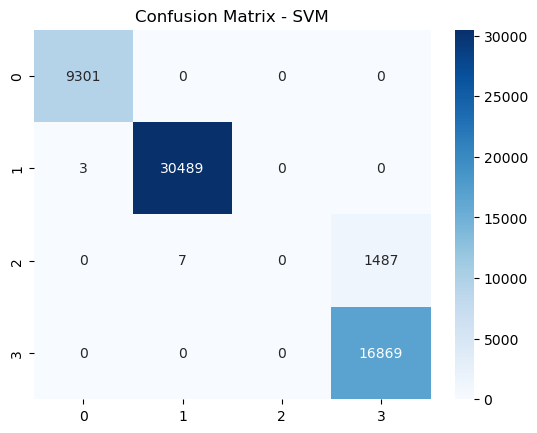

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 20}
Random Forest Classification Report (Tuned):
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      9301
     running       1.00      1.00      1.00     30492
      stairs       0.98      0.88      0.92      1494
     walking       0.99      1.00      0.99     16869

    accuracy                           1.00     58156
   macro avg       0.99      0.97      0.98     58156
weighted avg       1.00      1.00      1.00     58156



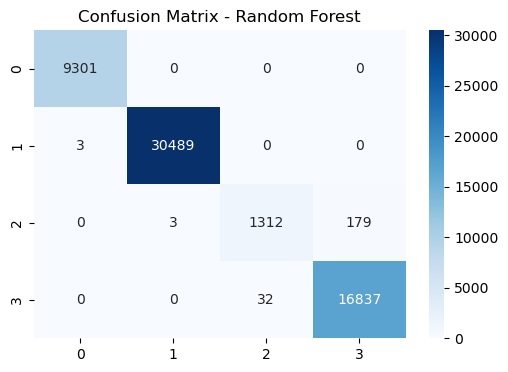

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best SVM Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
SVM Classification Report (Tuned):
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      9301
     running       1.00      1.00      1.00     30492
      stairs       0.91      0.22      0.36      1494
     walking       0.94      1.00      0.97     16869

    accuracy                           0.98     58156
   macro avg       0.96      0.81      0.83     58156
weighted avg       0.98      0.98      0.97     58156



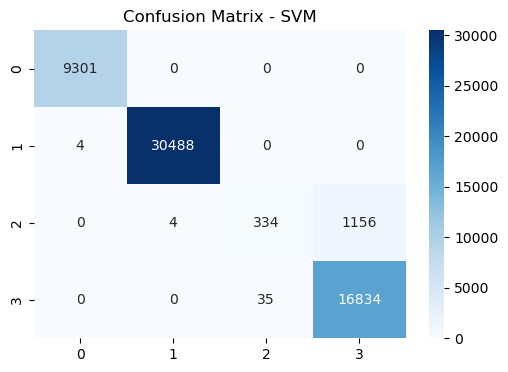

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import UndefinedMetricWarning 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to load data from a given folder
def load_data_from_folder(folder_path, label):
    files = os.listdir(folder_path)
    data_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path)
        data['label'] = label
        data_list.append(data)
    return pd.concat(data_list, ignore_index=True)

# Load all activity data
idle_data = load_data_from_folder('data/idle', 'idle')
running_data = load_data_from_folder('data/running', 'running')
stairs_data = load_data_from_folder('data/stairs', 'stairs')
walking_data = load_data_from_folder('data/walking', 'walking')

# Combine all activity data into one DataFrame
df = pd.concat([idle_data, running_data, stairs_data, walking_data], ignore_index=True)

# Feature Engineering (Time Domain Features)
df['x_mean'] = df['accelerometer_X'].rolling(window=10).mean()
df['y_mean'] = df['accelerometer_Y'].rolling(window=10).mean()
df['z_mean'] = df['accelerometer_Z'].rolling(window=10).mean()

df['x_var'] = df['accelerometer_X'].rolling(window=10).var()
df['y_var'] = df['accelerometer_Y'].rolling(window=10).var()
df['z_var'] = df['accelerometer_Z'].rolling(window=10).var()

# Calculate Signal Magnitude Area (SMA)
df['sma'] = (df['accelerometer_X'].abs() + df['accelerometer_Y'].abs() + df['accelerometer_Z'].abs()).rolling(window=10).mean()

# Calculate Root Mean Square (RMS)
df['x_rms'] = np.sqrt(df['accelerometer_X']**2).rolling(window=10).mean()
df['y_rms'] = np.sqrt(df['accelerometer_Y']**2).rolling(window=10).mean()
df['z_rms'] = np.sqrt(df['accelerometer_Z']**2).rolling(window=10).mean()

# Drop NaN rows introduced by rolling function
df.dropna(inplace=True)

# Separate features and labels
X = df.drop(columns=['label']) 
y = df['label']

print("Additional feature engineering complete.")


# Suppress warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and Evaluate Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set with Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Random Forest Accuracy Score:", accuracy_score(y_test, y_pred_rf))

# Confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Train and Evaluate SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set with SVM
y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, zero_division=0))
print("SVM Accuracy Score:", accuracy_score(y_test, y_pred_svm))

# Confusion matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - SVM')
plt.show()

# Reduced Hyperparameter Tuning for Random Forest using RandomizedSearchCV
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}

rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    n_iter=5,
    cv=2, 
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_random_search.fit(X_train, y_train)
print("Best Random Forest Parameters:", rf_random_search.best_params_)
best_rf_model = rf_random_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
print("Random Forest Classification Report (Tuned):")
print(classification_report(y_test, y_pred_best_rf))

# Plot Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Reduced Hyperparameter Tuning for SVM using RandomizedSearchCV
svm_param_grid = {
    'C': [1, 10],  
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale']
}

svm_random_search = RandomizedSearchCV(
    SVC(),
    svm_param_grid,
    n_iter=4, 
    cv=2, 
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

svm_random_search.fit(X_train, y_train)
print("Best SVM Parameters:", svm_random_search.best_params_)
best_svm_model = svm_random_search.best_estimator_
y_pred_best_svm = best_svm_model.predict(X_test)
print("SVM Classification Report (Tuned):")
print(classification_report(y_test, y_pred_best_svm))

# Plot Confusion Matrix for SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_best_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - SVM')
plt.show()